# ***`Human Emotions Detection`***

**Problem Statement:**

The objective of this project is to create an automated system that accurately identifies the emotional state depicted in input images. Specifically, the system needs to distinguish between three primary emotions: happiness, sadness, and anger. This capability will enable applications in various domains such as facial recognition, sentiment analysis, and human-computer interaction, enhancing user experience and engagement in real-world scenarios.

\
**Dataset**:

We are going to use the `Human Emotions Dataset` available on kaggle [click here](https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes).


## 1. Import dependencies

In [15]:
!wget https://github.com/krutika-shimpi/machine_learning_models/raw/main/helper_function.py

--2024-07-13 16:38:55--  https://github.com/krutika-shimpi/machine_learning_models/raw/main/helper_function.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/krutika-shimpi/machine_learning_models/main/helper_function.py [following]
--2024-07-13 16:38:55--  https://raw.githubusercontent.com/krutika-shimpi/machine_learning_models/main/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7764 (7.6K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]   7.58K  --.-KB/s    in 0s      

2024-07-13 16:38:56 (68.1 MB/s) - ‘helper_function.py’ 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

## 2. Get the data

Let's download the data from kaggle. We will import the data using the kaggle API.

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 308M/309M [00:17<00:00, 9.02MB/s]
100% 309M/309M [00:17<00:00, 18.2MB/s]


In [3]:
!unzip "/content/human-emotions-datasethes" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

## 3. Data Handling

Creating datasets from an image directory using tf.keras.utils.image_dataset_from_directory. Setting up configurations for global variables ensures standardized parameters for dataset loading

In [4]:
# Set up default configuration for global variables
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "N_EPOCHS": 20,
    "LEARNING_RATE": 0.001,
    "DROPOUT_RATE":0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE": 3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES":3
}

In [5]:
# Setup the data directories
train_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ['happy', 'sad', 'angry']

### 3.1 Creating a training dataset from a directory of images.

In [6]:
# Setup training and validation datasets from the image directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels = 'inferred',
    label_mode = 'categorical', # Output will be a one hot encoded vector [0,1,0]:[happy, sad, angry]
    class_names = CLASS_NAMES,
    batch_size = 32,
    image_size = (256, 256),
    shuffle = True,
    seed = 99,
    color_mode = 'rgb',
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = val_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99,
    color_mode = 'rgb',
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


### 3.2 Visualizing the dataset

Let's visualize some images from the datasets.

In [7]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

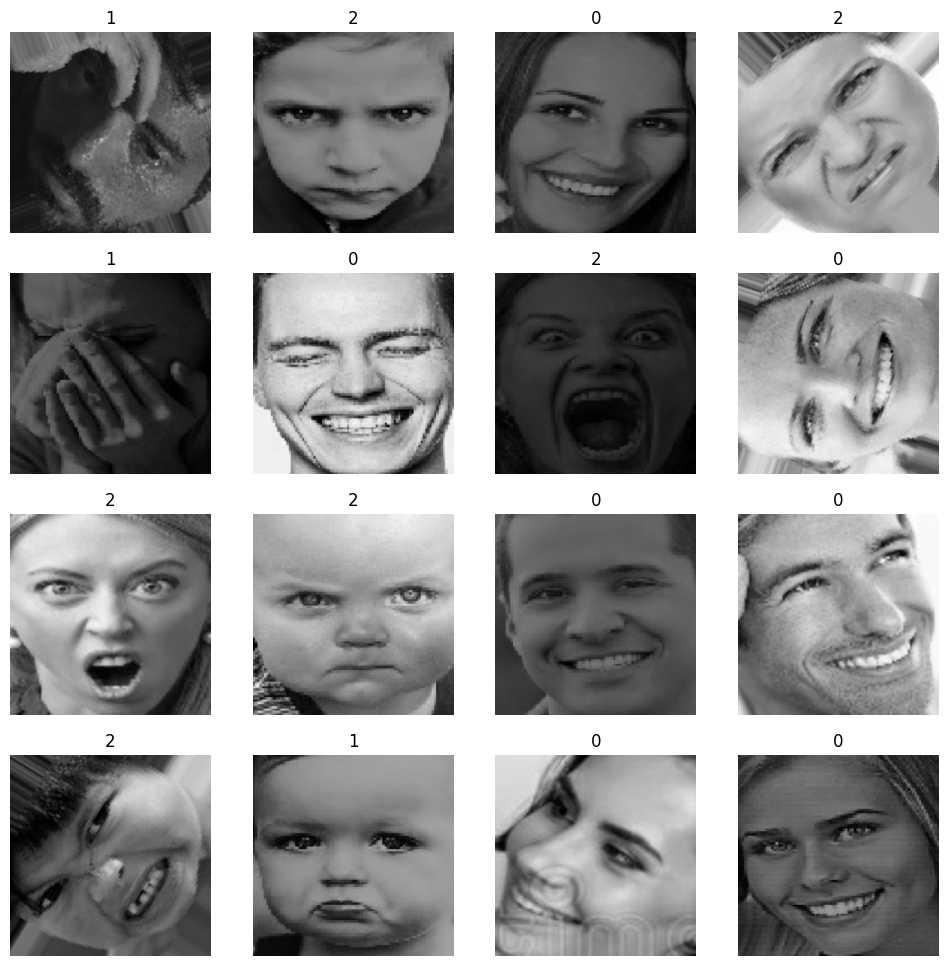

In [8]:
# Plot some images from the dataset
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.)
    plt.title(tf.argmax(labels[i], axis = 0).numpy())
    plt.axis("off")

### 3.3 Data Preparation

In [9]:
# Create prefetched datasets
training_dataset = (train_dataset
                    .prefetch(tf.data.AUTOTUNE))

validation_dataset = (val_dataset
                      .prefetch(tf.data.AUTOTUNE))

In [10]:
# Setting up resize and rescale methods as layers
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling(1./255)
])

## 4. Building the model

Let's now start working towards building the model, experimenting, documenting, and comparing the results of the models we build along the way.



In [24]:
# Model_0: Lenet model architecture

lenet_model = tf.keras.Sequential([
    # Input layer
    InputLayer(input_shape = (None, None, 3)),

    # Resizing and rescaling
    resize_rescale_layers,

    # Conv Layer 1
    Conv2D(filters = CONFIGURATION['N_FILTERS'],
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           padding = 'valid',
           activation = 'relu',
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),

    Dropout(CONFIGURATION['DROPOUT_RATE']),

    # Conv Layer 2
    Conv2D(filters = CONFIGURATION['N_FILTERS'] * 2 + 4,
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           padding = 'valid',
           activation = 'relu',
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),

    # Flatten Layer
    Flatten(),

    # Dense Layer 1
    Dense(units = CONFIGURATION['N_DENSE_1'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    # Dense layer 2
    Dense(units = CONFIGURATION['N_DENSE_2'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    # Output Layer
    Dense(units = CONFIGURATION['NUM_CLASSES'], activation = 'softmax')
])

# Print model summary
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

## 5. Training the model

Creating our own custom training loop.

In [25]:
# Setting up loss function
loss_function = CategoricalCrossentropy()

# Metrics for model evaluation
metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k = 3, name = 'top_k_accuracy')]

## 6. Compile the model


In [26]:
# Compile the model
lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
                    loss = loss_function,
                    metrics = metrics)

## 7. Fit the model

In [27]:
# Fit the model
lenet_history = lenet_model.fit(training_dataset,
                                epochs = CONFIGURATION['N_EPOCHS'],
                                validation_data = validation_dataset)

Epoch 1/20
213/213 [==============================] - 18s 68ms/step - loss: 0.9664 - accuracy: 0.5533 - top_k_accuracy: 1.0000 - val_loss: 1.0489 - val_accuracy: 0.5105 - val_top_k_accuracy: 1.0000
Epoch 2/20
213/213 [==============================] - 12s 57ms/step - loss: 0.6391 - accuracy: 0.7305 - top_k_accuracy: 1.0000 - val_loss: 0.8463 - val_accuracy: 0.6462 - val_top_k_accuracy: 1.0000
Epoch 3/20
213/213 [==============================] - 12s 56ms/step - loss: 0.4113 - accuracy: 0.8439 - top_k_accuracy: 1.0000 - val_loss: 0.9477 - val_accuracy: 0.6168 - val_top_k_accuracy: 1.0000
Epoch 4/20
213/213 [==============================] - 13s 55ms/step - loss: 0.2623 - accuracy: 0.9112 - top_k_accuracy: 1.0000 - val_loss: 0.7220 - val_accuracy: 0.7432 - val_top_k_accuracy: 1.0000
Epoch 5/20
213/213 [==============================] - 12s 56ms/step - loss: 0.1869 - accuracy: 0.9406 - top_k_accuracy: 1.0000 - val_loss: 1.0120 - val_accuracy: 0.5812 - val_top_k_accuracy: 1.0000
Epoch 6/20

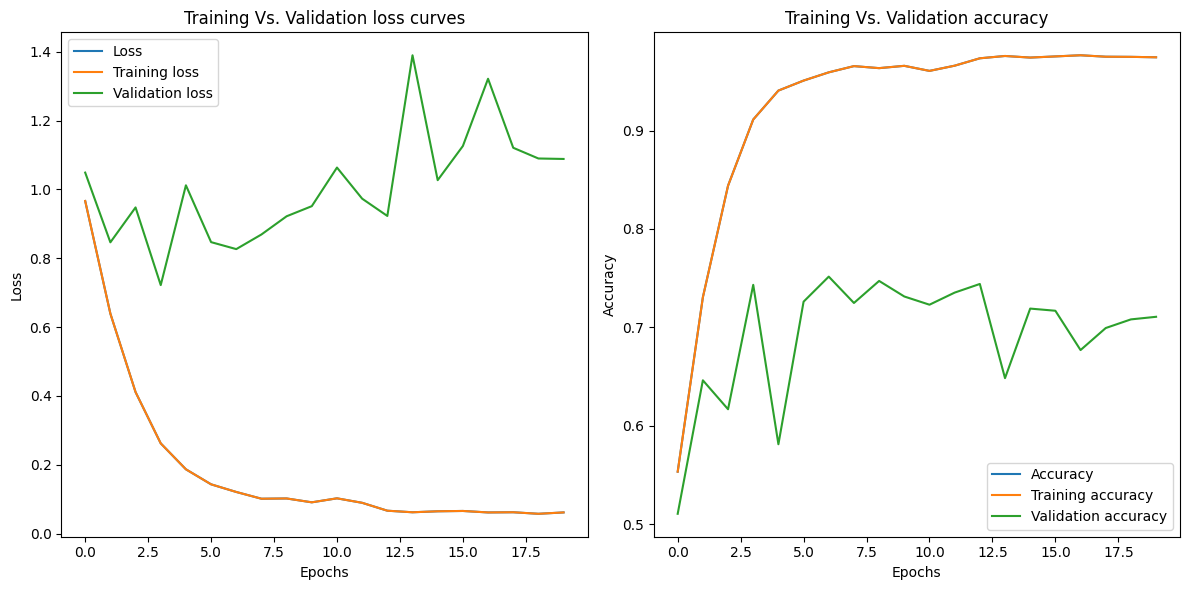

In [28]:
# Plot loss curves
from helper_function import plot_loss_curves
plot_loss_curves(lenet_history, classification = True, val_data = True)

## 8. Evaluation

In [29]:
# lets evaluate the modle on the val dataset
lenet_model.evaluate(validation_dataset)

72/72 [==============================] - 3s 32ms/step - loss: 1.0885 - accuracy: 0.7107 - top_k_accuracy: 1.0000


[1.088504433631897, 0.7107111215591431, 1.0]

## 9. Testing

In [34]:
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/108893.jpg')
im = tf.constant(test_image, tf.float32)
im = tf.expand_dims(im, axis = 0)
print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

sad


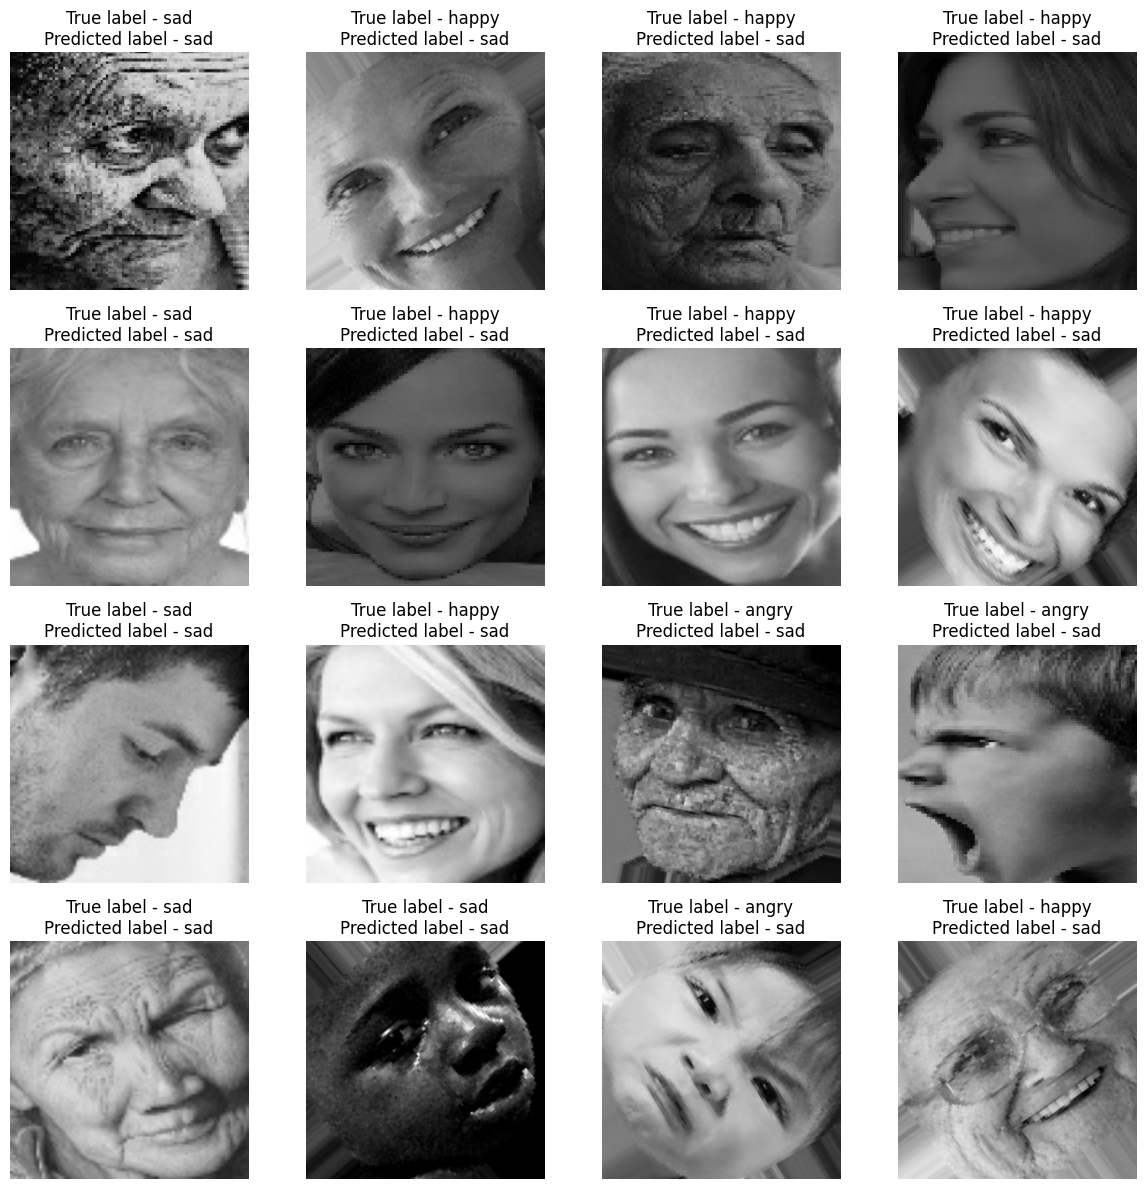

In [37]:
# Plot some images from the dataset
plt.figure(figsize = (12, 12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.)
    plt.title("True label - " + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()]+ "\nPredicted label - "+ CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])
    plt.axis("off")

plt.tight_layout()

### Plot the confusion matrix

In [38]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [42]:
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))

[0 1 1 ... 0 1 1]
[0 1 0 ... 0 2 0]


[[814 168  24]
 [141 564  52]
 [127 147 241]]


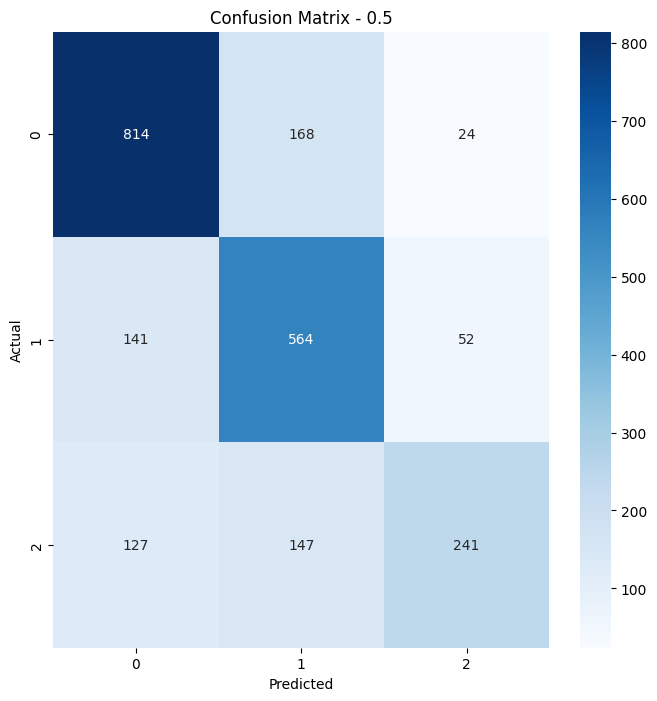

In [43]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

threshold = 0.5

cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize = (8,8))

sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix - {}'.format(threshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()